In [1]:
#from __future__ import print_function
%matplotlib inline
from options import Options
from lib.data import load_data
from lib.model import Ganomaly
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

from collections import OrderedDict
import glob,os
import shutil
import time
import numpy as np
from tqdm import tqdm

from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.utils.data
import torchvision.utils as vutils

from lib.networks import NetG, NetD, weights_init
from lib.visualizer import Visualizer
from lib.loss import l2_loss
from lib.evaluate import evaluate

import pandas as pd

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
#### Put your images in data/test/1.abnormal, 3*64*64  if you are using the trained model descripted in the paper
#### No need to change anything here, if you are using the trained model descripted in the paper
#### If you trained your own model, change iszie, nc, nz to match your new model
class Args:
    dataset='test' ##Put your images in data/test/1.abnormal
    dataroot=''
    batchsize=1   #batch size, set to 1 when testing
    workers=8
    droplast=False
    isize=64      #input image size.
    nc=3          #input image channels
    nz=128        #size of the latent z vector
    ngf=64
    ndf=64
    extralayers=0 #Number of extra layers on gen and disc
    device='gpu'  #You do need a GPU to run this
    gpu_ids='0'
    ngpu=1
    name='ganomaly/test'
    model='ganomaly'
    display_server="http://localhost"
    display_port=8097
    display_id=0
    display=True   #Use visdom
    outf='./output'
    manualseed=-1   #manual seed
    
    
    
    load_weights=True     #Load the pretrained weights
    resume=''             #path to checkpoints (to continue training

    isTrain = False  #True
    opt = None
    
opt = Args()
dataloader = load_data(opt)

In [4]:
model = Ganomaly(opt, dataloader)

Setting up a new session...


   Loaded weights.


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


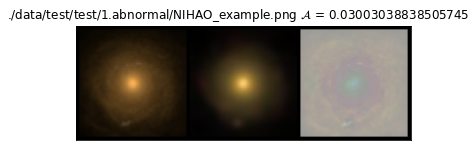

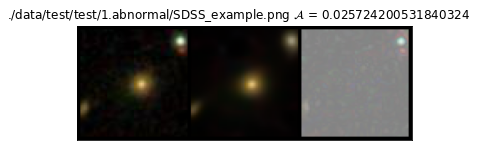

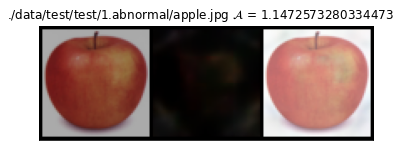

In [5]:
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
#plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams.update({'figure.max_open_warning': 0})


def show(imgs,score,name):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    fix.suptitle(name+' $\mathcal{A}$ = '+str(score),y=0.77)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

with torch.no_grad():
        # Load the weights of netg and netd.
        if model.opt.load_weights:
            path = "./output/ganomaly/SDSS/train/weights/netG_43.pth"
            pretrained_dict = torch.load(path)['state_dict']

            try:
                model.netg.load_state_dict(pretrained_dict)
            except IOError:
                raise IOError("netG weights not found")
            print('   Loaded weights.')

        model.opt.phase = 'test'
        #model.netg.eval()
        # note: why not use model.netg.eval(), but only torch.no_grad() ? (see: https://github.com/samet-akcay/ganomaly/issues/83)
        # "This has come up before with the associated skip-ganomaly repo (https://github.com/samet-akcay/skip-ganomaly)
        #  I asked Samet Akcay, the first author [I am also a co-author on the GANomaly paper but my familiarity with the code-base 
        # is essentially zero] and he said "..it’s not a bug. During the DCGAN era, it was common not to put the model on eval mode 
        # for the stability. What I did instead, is to use batch norm, and batch size of 1 during the test so the performance is not 
        # affected. 
        # If you add .eval() it significantly reduces the AUC performance against this batch size of 1 approach 
        # - ourselves and others have found this. AFIAK, there is no dropout in use in this approach." -- tobybreckon 

        
        loss_con=nn.L1Loss(reduction='none')
        ascore_array=np.zeros(len(model.dataloader['test']))

        for i, data in tqdm(enumerate(model.dataloader['test'], 0),total=len(model.dataloader['test'])):
            model.set_input(data)
            model.fake, latent_i, latent_o = model.netg(model.input)

            error = torch.mean(torch.pow((latent_i-latent_o), 2), dim=1)

            ascore = error.reshape(error.size(0))
            
            ascore_array[i]=ascore
            
            #original_feature=latent_i.cpu().detach().numpy()
            #original_feature=original_feature.reshape((Args.batchsize,Args.nz))
            
            real, fake, _ = model.get_current_images()
            loss_img=loss_con(model.fake,model.input).data
            grid=make_grid([real[0],fake[0],loss_img[0]],normalize=True)
            name=model.dataloader['test'].dataset.samples[i][0]
            
            ## comment show() to disable plot images
            show(grid,ascore_array[i],name)
            
            ## uncomment if you want to save the images.
            ## the output image is saved at "./output/ganomaly/test/test/image/"
            plt.savefig(opt.outf+'/ganomaly/test/test/images/'+str(i)+'.png')

In [6]:
# anomaly scores
ascore_array

array([0.03003039, 0.0257242 , 1.14725733])

In [7]:
# filenmaes
model.dataloader['test'].dataset.samples

[('./data/test/test/1.abnormal/NIHAO_example.png', 1),
 ('./data/test/test/1.abnormal/SDSS_example.png', 1),
 ('./data/test/test/1.abnormal/apple.jpg', 1)]

In [8]:
## normalize your anomaly score from 0~1
## in the paper anomaly scores are normalized, but if your are only testing 1 or 2 images, probably not very meaningful to normalize
## uncomment to normalize
# ascore_array=(ascore_array-ascore_array.min())/(ascore_array.max()-ascore_array.min())

In [9]:
# get a pandas table for anomaly scores
df=pd.DataFrame(model.dataloader['test'].dataset.samples,columns=['filename','ascore'])
df['ascore']=ascore_array
df

,filename,ascore
0,./data/test/test/1.abnormal/NIHAO_example.png,0.030030
1,./data/test/test/1.abnormal/SDSS_example.png,0.025724
2,./data/test/test/1.abnormal/apple.jpg,1.147257
